An initial attempt at a study justifying the number of iterations used for Uni-/MultiFold.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

In [196]:
### Generic imports
# from __future__ import absolute_import, division, print_function
import numpy as np
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

### ML imports
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
import livelossplot

### Custom functions
# from ntupleanalysis import *
from omnifold import *
from omnifold.utilities import *

In [4]:
plot_setup()

In [5]:
plot_dir = './plots/'
save_label0 = 'iteration_test'

### Load files

Since we're not using data yet, "MC" = Powheg + Pythia8 MC16e and "data" = Sherpa 2.2.1 MC16e.

In [80]:
folder = '/clusterfs/ml4hep/adisurtya/ATLASOmniFold/slimmedSamples/'

In [81]:
f_mc = uproot.open(folder+"ZjetOmnifold_Jun25_PowhegPythia_mc16e_slim.root")
f_data = uproot.open(folder+"ZjetOmnifold_Jun25_Sherpa221_mc16e_slim.root")

In [82]:
columns = f_mc['OmniTree'].keys()

These columns are the same for both samples, since they're both MC:

In [85]:
f_mc['OmniTree'].keys() == f_data['OmniTree'].keys()

True

Note that variables ending in `_tracks` require MultiIndex-ing. It's possible to combine these with flat variables, but it does increase the size of the DataFrame considerably: 

In [76]:
[col for col in columns if col.endswith("_tracks")]

['pT_tracks',
 'eta_tracks',
 'phi_tracks',
 'trackJetIndex_tracks',
 'truth_pT_tracks',
 'truth_eta_tracks',
 'truth_phi_tracks',
 'truth_trackJetIndex_tracks']

In [77]:
f_mc['OmniTree'].arrays(
    ["weight","pT_tracks"],
#     [col for col in columns if col.endswith("tracks")],
    filter_name="pT_tracks", 
    library="pd")

weight  pT_tracks
entry  subentry                     
0      0         0.241816  33.519623
       1         0.241816  32.295208
       2         0.241816  27.368732
       3         0.241816  25.860355
       4         0.241816   3.398118
...                   ...        ...
416724 59        0.205618   0.606367
       60        0.205618   0.598488
       61        0.205618   0.578678
       62        0.205618   0.567151
       63        0.205618   0.564475

[22300697 rows x 2 columns]

Let's ignore the MultiIndex variables for now.

In [89]:
mc = f_mc['OmniTree'].arrays(
    [col for col in columns if not col.endswith("_tracks")],
    library="pd")

data = f_data['OmniTree'].arrays(
    [col for col in columns if not col.endswith("_tracks")],
    library="pd")

print("MC has {:,} events with {} columns.".format(mc.shape[0],mc.shape[1]))
print("Data has {:,} events with {} columns.".format(data.shape[0],data.shape[1]))

MC has 416,725 events with 57 columns.
Data has 3,578,623 events with 57 columns.


### Apply event selection

In [97]:
mc['pass190'] = mc['pass190'].astype('bool')
mc['truth_pass190'] = mc['truth_pass190'].astype('bool')
data['pass190'] = data['pass190'].astype('bool')
data['truth_pass190'] = data['truth_pass190'].astype('bool')

In [101]:
mc_truth_weights = mc[mc.truth_pass190].weight_mc
mc_reco_weights = mc[mc.pass190].weight

data_truth_weights = data[data.truth_pass190].weight_mc
data_reco_weights = data[data.pass190].weight

Normalize the weights:

In [103]:
for weights in [mc_truth_weights, mc_reco_weights, data_truth_weights, data_reco_weights]:
    weights /= np.mean(weights)

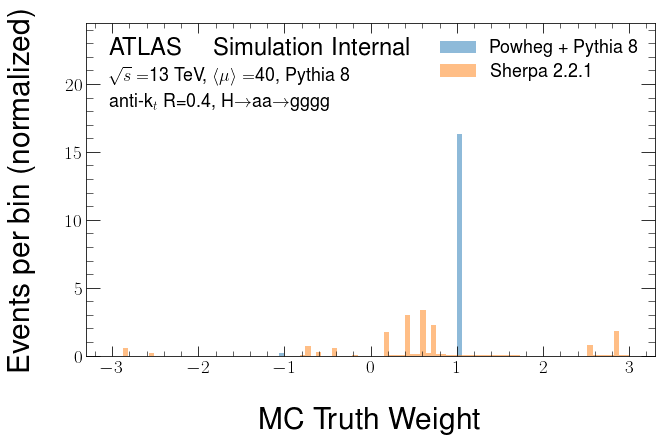

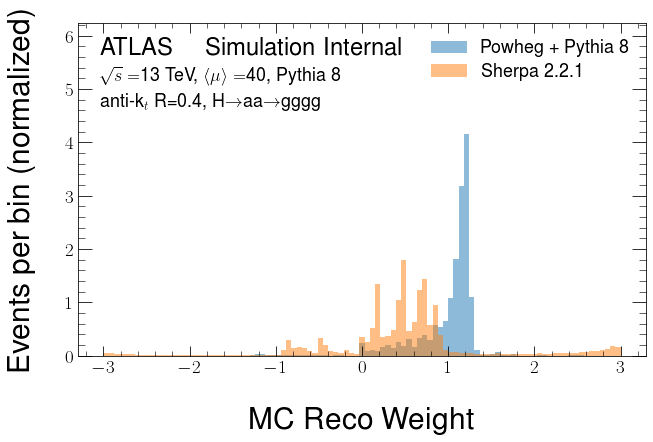

In [105]:
bins = np.linspace(-3, 3, 100)

plt.figure(figsize=(10, 6))
hW_sim_truth, _, _ = plt.hist(mc_truth_weights,
                              bins=bins,
                              label=r'Powheg + Pythia 8',
                              **plot_style_2)
hW_data_truth, _, _ = plt.hist(data_truth_weights,
                               bins=bins,
                               label=r'Sherpa 2.2.1',
                               **plot_style_2)
plt.xlabel('MC Truth Weight')
plt.ylabel('Events per bin (normalized)')
plt.ylim(top=1.5 * np.max((hW_sim_truth, hW_data_truth)))
plt.legend()
draw_atlas_text()
plt.show()

plt.figure(figsize=(10, 6))
hW_sim_reco, _, _ = plt.hist(mc_reco_weights,
                             bins=bins,
                             label=r'Powheg + Pythia 8',
                             **plot_style_2)
hW_data_reco, _, _ = plt.hist(data_reco_weights,
                              bins=bins,
                              label=r'Sherpa 2.2.1',
                              **plot_style_2)
plt.xlabel('MC Reco Weight')
plt.ylabel('Events per bin (normalized)')
plt.ylim(top=1.5 * np.max((hW_sim_reco, hW_data_reco)))
plt.legend()
draw_atlas_text()
plt.show()

### Load IBU histograms?

In [138]:
file_labels = [
    'Ntracks_trackj1', 'Ntracks_trackj2', 'm_trackj1', 'm_trackj2',
    'pT_trackj1', 'pT_trackj2', 'y_trackj1', 'y_trackj2', 'phi_trackj1',
    'phi_trackj2', 'tau1_trackj1', 'tau1_trackj2', 'tau2_trackj1',
    'tau2_trackj2', 'tau3_trackj1', 'tau3_trackj2', 'pT_ll', 'y_ll', 'pT_l1',
    'pT_l2', 'eta_l1', 'eta_l2', 'phi_l1', 'phi_l2'
]
plot_labels = [
    r'Leading track jet $n_{\textrm{ch}}$ ',
    r'Subleading track jet $n_{\textrm{ch}}$', 'Leading track jet $m$ [GeV]',
    r'Subleading track jet $m$ [GeV]', r'Leading track jet $p_T$ [GeV]',
    r'Subleading track jet $p_T$ [GeV]', r'Leading track jet $y$',
    r'Subleading track jet $y$', r'Leading track jet $\phi$',
    r'Subleading track jet $\phi$', r'Leading track jet $\tau_1$',
    r'Subleading track jet $\tau_1$', r'Leading track jet $\tau_2$',
    r'Subleading track jet $\tau_2$', r'Leading track jet $\tau_3$',
    r'Subleading track jet $\tau_3$', r'$p^{\mu \mu}_T$ [GeV]',
    r'$y_{\mu \mu}$', r'$p^{\mu 1}_{T}$ [GeV]', r'$p^{\mu 2}_{T}$ [GeV]',
    '$\eta_{\mu 1}$', '$\eta_{\mu 2}$', '$\phi_{\mu 1}$', '$\phi_{\mu 2}$'
]

In [120]:
IBU_hists = uproot.open('/clusterfs/ml4hep/adisurtya/ATLASOmniFold/unfoldingPlotsJune14_UnfoldedHists.root')

In [177]:
bins = []
for label in file_labels:
    bins += [IBU_hists['SherpaUnfoldWPythia_2018_'+label].to_numpy()[1]]

In [133]:
# keys = [key for key in IBU_hists.keys() if key.startswith('SherpaUnfoldWPythia_2018')]
# bins = []
# for key in keys:
#     bins += [IBU_hists[key].to_numpy()[1]]

In [178]:
labels_and_bins = zip(file_labels, plot_labels, bins)

obs = []

for file_label, plot_label, plot_bins in labels_and_bins:
    obs += [{
        'file_label': file_label,
        'plot_label': plot_label,
        'bins': plot_bins
    }]

In [179]:
obs_df = pd.DataFrame(obs)

In [180]:
obs_df

,file_label,plot_label,bins
0,Ntracks_trackj1,Leading track jet $n_{\textrm{ch}}$,"[1.0, 5.0, 7.0, 10.0, 13.0, 16.0, 20.0, 30.0, ..."
1,Ntracks_trackj2,Subleading track jet $n_{\textrm{ch}}$,"[1.0, 2.0, 3.0, 5.0, 7.0, 9.0, 11.0, 15.0, 20...."
2,m_trackj1,Leading track jet $m$ [GeV],"[0.0, 10.0, 20.0, 30.0, 40.0, 80.0]"
3,m_trackj2,Subleading track jet $m$ [GeV],"[0.0, 2.5, 5.0, 10.0, 20.0, 70.0]"
4,pT_trackj1,Leading track jet $p_T$ [GeV],"[0.0, 50.0, 100.0, 150.0, 200.0, 300.0, 1000.0]"
5,pT_trackj2,Subleading track jet $p_T$ [GeV],"[0.0, 25.0, 50.0, 100.0, 700.0]"
6,y_trackj1,Leading track jet $y$,"[-2.5, -2.25, -2.0, -1.75, -1.5, -1.25, -1.0, ..."
7,y_trackj2,Subleading track jet $y$,"[-2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, ..."
8,phi_trackj1,Leading track jet $\phi$,"[-3.2, -3.0, -2.8, -2.6, -2.4, -2.2, -2.0, -1...."
9,phi_trackj2,Subleading track jet $\phi$,"[-3.2, -2.8, -2.4, -2.0, -1.6, -1.2, -0.8, -0...."


### Unifold

In [181]:
K.clear_session()

In [182]:
unifold_weights = np.zeros(shape=(len(obs), len(mc_truth_weights)))

In [183]:
obs_index = 0
bins = obs[obs_index]['bins']
x_label = obs[obs_index]['plot_label']
file_label = obs[obs_index]['file_label']
save_label = plot_dir + 'UniFold/' + file_label + '/' + save_label0 + '-UniFold-' + file_label

In [186]:
mc_truth = mc[mc['truth_pass190']]['truth_' + file_label]
mc_reco = mc[mc['pass190']][file_label]

data_truth = data[data['truth_pass190']]['truth_' + file_label]
data_reco = data[data['pass190']][file_label]

/clusterfs/ml4hep/mpettee/ATLASOmniFold/omnifold/plot.py:94: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


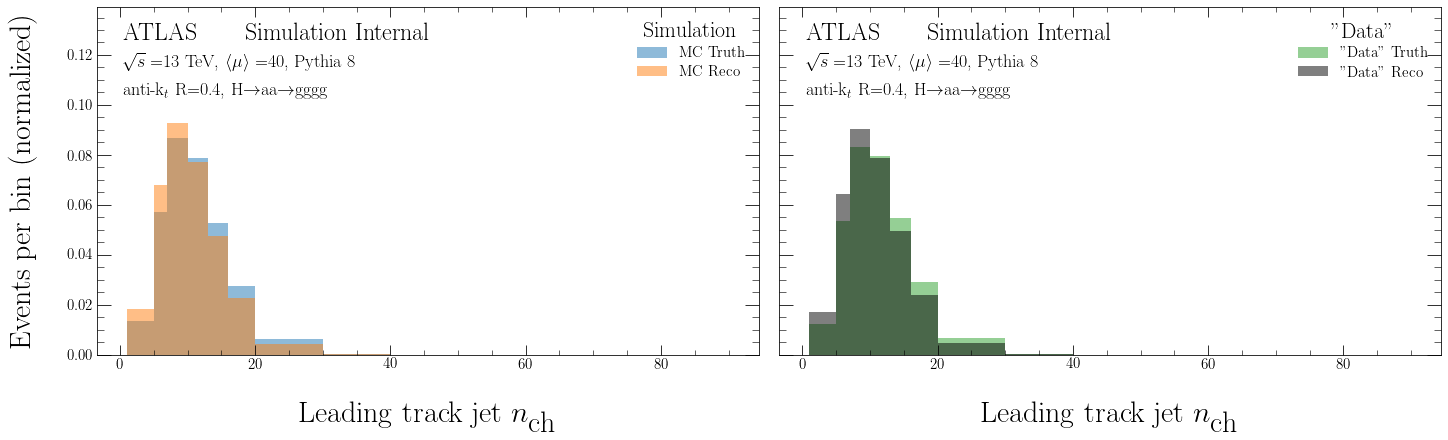

In [189]:
plot_distributions(
    sim_truth=mc_truth,
    sim_reco=mc_reco,
    sim_truth_weights_MC=mc_truth_weights,
    sim_reco_weights_MC=mc_reco_weights,
    data_truth=data_truth,
    data_reco=data_reco,
    data_truth_weights_MC=data_truth_weights,
    data_reco_weights_MC=data_reco_weights,
    bins=bins,
    x_label=x_label,
#     save_label=save_label
)

In [197]:
# z-score standardization of data

mc_truth_z, mc_reco_z, data_reco_z = standardize(mc_truth, 
                                                   mc_reco,
                                                   data_reco)

AttributeError: 'Series' object has no attribute 'reshape'